In [2]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from glob import glob

sns.set()

sys.path.append('../')
from modules.datasets import dataset_utils, ucr_loader

%load_ext autoreload
%autoreload 2

In [3]:
# config
root = '../../results/'
exp = 'baseline'
subset = 100.0
dataset = 'CharacterTrajectories'
labels = ['a', 'b', 'c', 'd', 'e', 'g', 'h', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 'u', 'v', 'w', 'y', 'z']

In [4]:
# get dataset and attribution
np.random.seed(0)

######### Dataset processing ###########
dataset_dict = ucr_loader.get_datasets("../../data/", prefix='**/')
trainX, trainY, testX, testY = ucr_loader.load_data(dataset_dict[dataset])
trainX, trainY, testX, testY = dataset_utils.preprocess_data(trainX, trainY, testX, testY, normalize=False, standardize=False, channel_first=True)

##### Subset creation for attr #########
sub_testX, sub_testY, sub_ids = dataset_utils.sub_sample(testX, testY, subset)

In [5]:
########### collect attr maps ##########
def collect_attrs(exp, dataset, subset):
    attrs = {}
    for fname in glob('../../models/%s/%s/**/subset_%s/**/**_attr.npy' % (exp, dataset, subset)):
        method = fname.split('/')[-1].split('_')[0]
        attrs[method] = np.load(fname, allow_pickle=True)[1]
    return attrs
attrs = collect_attrs(exp, dataset, subset)

In [6]:
def transform_2d(timeseries):
    trans = np.zeros((3, timeseries.shape[1]+1))
    for i in range(timeseries.shape[1]):
        trans[:, i+1] = trans[:, i] + timeseries[:, i]
    trans = trans[:, 1:]
    return trans

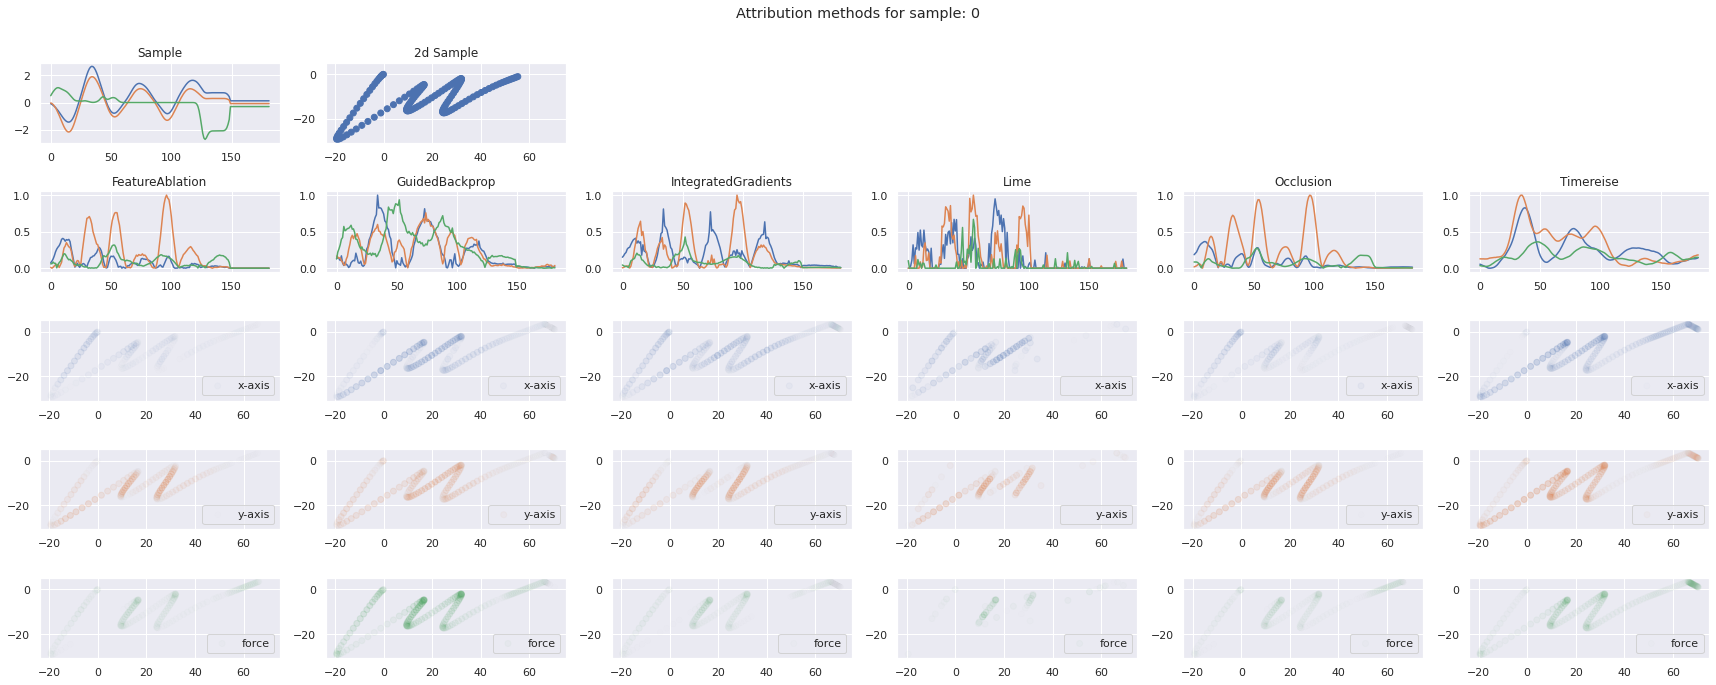

In [8]:
def plot_approaches_char(data, attrs, index=0, save_path=None):
        approaches_exec = [a for a in sorted(attrs)]
        label = ['x-axis', 'y-axis', 'force']
        trans = transform_2d(data[index])
        cols = len(approaches_exec)
        fig, ax = plt.subplots(nrows=5, ncols=cols,
                               figsize=(4*cols, 10))
        fig.suptitle('Attribution methods for sample: ' + str(index))
        axes = ax.flat
        axes[0].set_title('Sample')
        axes[0].plot(data[index].T)
        axes[1].set_title('2d Sample')
        axes[1].scatter(trans[0], trans[1], alpha=trans[2].clip(0,1))
        for i in range(2, cols):
            axes[i].set_visible(False)
        for c, name in enumerate(sorted(approaches_exec)):
            axes[c+cols].set_title(name)
            axes[c+cols].plot(attrs[name][index].T)
            for chl in range(data[index].shape[0]):
                axes[c+(2+chl)*cols].scatter(trans[0], trans[1],
                    c='C'+str(chl), alpha=0.25*attrs[name][index][chl],
                    label= label[chl])
                axes[c+(2+chl)*cols].legend()
            
        fig.tight_layout(rect=[0, 0.03, 1, 0.98])

        if save_path is not None:
            fname = 'Attribution_Approaches_char_id-' + str(index) + '.png'
            plt.savefig(os.path.join(save_path, 'paper_figures', fname), dpi=300,
                        bbox_inches='tight', pad_inches=0.1)
        plt.show()

plot_approaches_char(sub_testX, attrs, index=0, save_path=root)